# notebook to score all the datasets with the CoVES vs others
- create table of unsupervised methods (CoVES, ESM-IF, proteinMPNN, BLOSUM, EvCouplings)
- scoring of AT 3pos, AT 10pos, GFP, AAV, GRB2


In [25]:
from os import listdir
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from scipy.stats import pearsonr, spearmanr
import pandas as pd
import importlib

import sys
sys.path.append('../src/')

import covesTools
importlib.reload(covesTools)
import covesTools as ct
import dataTools as dt

### get the right plt style
plt.style.use('../src/paper_style1.mplstyle')

## adding the arial font that had to be downloaded
import matplotlib.font_manager as font_manager

# Add every font at the specified location
font_dir = ['../src/fonts/']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

font_manager.findfont('arial') 
from matplotlib import rcParams
rcParams['font.family'] = 'arial'

dout = '../data/out/'

coves_pred_dir = '../data/coves/preferences/'
ev_mut_dir = '../data/coves/scores/evmut/'
pmpnn_dir = '../data/coves/scores/protein_mpnn_scores/'
esm_dir = '../data/coves/scores/esm_scores/'
score_dout = '../coves/scores/all_scores/'


# AT libraries scoring

In [5]:
x,y,df_at_3p = dt.get_x_y_at_3p()
x,y,df_at_10p = dt.get_x_y_at_10p()
df_at_3p['muts_m1'] = df_at_3p.apply(lambda r: ':'.join([mut[0] + str(int(mut[1:-1])+1) + mut[-1] for mut in r.name.split(':')]), axis=1)
df_at_10p['muts_m1'] = df_at_10p.muts.apply(lambda m: ':'.join([mut[0] + str(int(mut[1:-1])+1) + mut[-1] for mut in m.split(':')]))


## scoring with CoVES

In [7]:
# scoring with CoVES

# get the structure scores
df_gvp_pred = ct.read_res_pred(coves_pred_dir+'gvp_100_m_at_1646945484.3030427_8_220711.csv')

# normalize scores for each position to be probabilities and log_probabilities
df_gvp_pred=ct.add_p_col_df_gvp_log(df_gvp_pred, t=0.1)

# 3 position 
df_at_3p['coves_pred_t0.1'] = df_at_3p.muts_m1.apply(
    lambda m: ct.get_joint_log_prob_mutants(df_gvp_pred, m, p_col = 'log_p_t0.1'))
# 10 pos

df_at_10p['coves_pred_t0.1'] = df_at_10p.muts_m1.apply(
    lambda m: ct.get_joint_log_prob_mutants(df_gvp_pred, m, p_col = 'log_p_t0.1'))


## fetch and merge other scores

In [6]:
# add blosum scores to at datasets

# 10 positino antitoxin
df_at_10p['blosum_score'] = df_at_10p.apply(lambda r: ct.blosum_score(''.join([m[0] for m in r.muts.split(':')]),
                                                                   ''.join([m[-1] for m in r.muts.split(':')])
                                                                  ),axis=1)
# 3 position antitoxin
df_at_3p['blosum_score'] = df_at_3p.apply(lambda r: ct.blosum_score(''.join([m[0] for m in r.name.split(':')]),
                                                                   ''.join([m[-1] for m in r.name.split(':')])
                                                                  ),axis=1)

In [15]:
# get evmutation scores
df_10p_evmut = pd.read_csv(ev_mut_dir + 'df_704_10x_rc3_col_processed_evmut.csv')
df_3p_evmut = pd.read_csv(ev_mut_dir + 'df_mut_all_norm_evmut.csv')

In [22]:
# load proteinMPNN scores
df_pmpnn_10p = pd.read_csv(pmpnn_dir + 'df_10pos_proteinmpnn_score.csv')
df_pmpnn_10p = df_pmpnn_10p.rename(columns = {'score':'proteinMPNN', 'RES_pred': 'RES'})[['mutkey_m1', 'proteinMPNN']]
df_pmpnn_3p = pd.read_csv(pmpnn_dir + 'df_3pos_proteinmpnn_score.csv')
df_pmpnn_3p = df_pmpnn_3p.rename(columns = {'score':'proteinMPNN', 'RES_pred': 'RES'})[['mutkey_m1', 'proteinMPNN']]

# load esm-IF scores
df_10p_esm = pd.read_csv(esm_dir + 'df_704_10x_exp_no_stop_scores.csv', header=None).rename(columns={0:'mutkey', 1:'seq', 2:'ESM', 3:'ESM2'})
df_3p_esm = pd.read_csv(esm_dir + 'df_mut_all_no_stop_scores.csv', header=None).rename(columns={0:'mutkey', 1:'seq', 2:'ESM', 3:'ESM2'})

In [18]:
# merge into a single deduplicated df
########## AT 3 pos library
# at 3pos library
df_at_3p_merge = df_at_3p[['E3','muts_m1', 'blosum_score', 'coves_pred_t0.1']] # duplicates are the synonymous wt AT
df_at_3p_merge = df_at_3p_merge.merge(df_3p_evmut[['mut_m1', 'evc_pred']], left_on = 'muts_m1', right_on = 'mut_m1')
df_at_3p_merge = df_at_3p_merge.merge(df_pmpnn_3p, left_on='mut_m1', right_on = 'mutkey_m1')
df_at_3p_merge = df_at_3p_merge.merge(df_3p_esm[['mutkey', 'ESM']], left_on='muts_m1', right_on = 'mutkey')

######### at 10pos library
df_10p_merge = df_at_10p[['mean_lrr_norm','muts_m1', 'blosum_score', 'coves_pred_t0.1', ]] # duplicates are the synonymous wt AT
# deduplicate any synonymous mutant observations
df_10p_merge = df_10p_merge.groupby('muts_m1').mean()
df_10p_evmut = df_10p_evmut[['mut_m1','evc_pred']].groupby('mut_m1').mean()
df_10p_merge = df_10p_merge.merge(df_10p_evmut, left_index=True, right_index=True)
df_pmpnn_10p = df_pmpnn_10p.groupby('mutkey_m1').mean()
df_10p_merge = df_10p_merge.merge(df_pmpnn_10p, left_index=True, right_index=True)
df_10p_esm = df_10p_esm[['mutkey', 'ESM']].groupby('mutkey').mean()
df_10p_merge = df_10p_merge.merge(df_10p_esm, left_index=True, right_index=True)
print(df_10p_merge.shape)

(7923, 6)


# scoring: GFP, AAV, GRB2

In [23]:
def merge_esm_mpnn_evh(prot_n, seq_col_n = 'mutated_sequence'):
    df_evh = pd.read_csv(ev_mut_dir +f'{prot_n}_dms_scores_evh.csv')
    df_mpnn = pd.read_csv(pmpnn_dir +f'{prot_n}_dms_scores_MPNN.csv')
    df_esmif = pd.read_csv(esm_dir +f'{prot_n}_dms_scores_ESMIF.csv')
    df_all = df_evh[[seq_col_n, 'mutant', 'DMS_score', 'hamiltonians']].rename(columns = {'hamiltonians': 'evmut'})
    df_all = df_all.merge(df_mpnn[['Protein_MPNN_score', 'mutant']], left_on='mutant', right_on='mutant')
    df_all = df_all.merge(df_esmif[['log_likelihood', 'mutant']].rename(columns={'log_likelihood':'ESM'}), left_on='mutant', right_on='mutant')
    return df_all


In [24]:

df_all_grb2 = merge_esm_mpnn_evh('GRB2_HUMAN')
df_all_gfp = merge_esm_mpnn_evh('GFP_AEQVI')
df_all_aav = merge_esm_mpnn_evh('CAPSD_AAV2S', seq_col_n = 'mutated_region')


In [181]:
df_all_grb2['blosum'] = df_all_grb2.apply(lambda r: ct.blosum_score(''.join([m[0] for m in str(r.mutant).split(':')]),
                                                                   ''.join([m[-1] for m in str(r.mutant).split(':')])
                                                                  ),
                                         axis=1)


df_all_gfp['blosum'] = df_all_gfp.apply(lambda r: ct.blosum_score(''.join([m[0] for m in str(r.mutant).split(':')]),
                                                                   ''.join([m[-1] for m in str(r.mutant).split(':')])
                                                                  ),
                                         axis=1)
df_all_aav['blosum'] = df_all_aav.apply(lambda r: ct.blosum_score(''.join([m[0] for m in str(r.mutant).split(':')]),
                                                                   ''.join([m[-1] for m in str(r.mutant).split(':')])
                                                                  ),
                                         axis=1)

## adding RES pred for 3 proteins

In [196]:
#gfp
df_gvp_pred = ct.read_res_pred(coves_pred_dir +'gvp_100_m_gfp_230523_.csv')
df_gvp_pred=ct.add_p_col_df_gvp_log(df_gvp_pred, t=0.1)
df_all_gfp['RES_pred'] = df_all_gfp.mutant.apply(lambda m: ct.get_joint_log_prob_mutants(df_gvp_pred, m, p_col = 'log_p_t0.1'))

index_error with mut:A110D:N146D:I188V:M233T:L236P
index_error with mut:A110G:K140M:R168C:L236P
index_error with mut:A110V:E111D:N212S:D234N
index_error with mut:A154G:N159S:E235G
index_error with mut:A154S:N159T:L236P
index_error with mut:A154T:E235G
index_error with mut:A179V:L236Q
index_error with mut:A206T:E235K
index_error with mut:A206T:G232D
index_error with mut:A226T:D234G
index_error with mut:A227V:M233K
index_error with mut:A37P:N149S:Q157L:Q204L:Y237H
index_error with mut:A37S:E235G
index_error with mut:A37T:E124V:K156R:L236Q
index_error with mut:A37T:F83S:F100S:I136T:M153L:Q157R:K158E:F165L:M218K:I229T:L236P
index_error with mut:A37T:F99S:N212D:E235V
index_error with mut:A37T:G67D:D133G
index_error with mut:A37T:I136N:M218L:Y237H
index_error with mut:A37T:M78T:F100L:E132G:K140R:I152V:K209E:E222G:Y237H
index_error with mut:A37T:N159Y:N170D:G232D
index_error with mut:A37T:P56L:D117G:G127R:G138E:F165S:Y237F
index_error with mut:A37V:P187L:M233T
index_error with mut:A37V:S72G:D

In [210]:
#grb2
df_gvp_pred = ct.read_res_pred(coves_pred_dir +'gvp_100_m_grb2_230523_.csv')

# normalize scores for each position to be probabilities and log_probabilities
df_gvp_pred=ct.add_p_col_df_gvp_log(df_gvp_pred, t=0.1)

df_all_grb2 = df_all_grb2.dropna()
# get correct index
df_all_grb2['mut_T1'] = df_all_grb2.mutant.astype(str).apply(
        lambda m: ':'.join(
            [(mut[0] + str(int(mut[1:-1])-158) + m[-1]) for mut in m.split(':')]
        )
    )


df_all_grb2['RES_pred'] = df_all_grb2.mut_T1.apply(lambda m: ct.get_joint_log_prob_mutants(df_gvp_pred, m, p_col = 'log_p_t0.1'))


index_error with mut:T1M:P54M
index_error with mut:T1E:P54E
index_error with mut:T1G:P54G
index_error with mut:T1R:P54R
index_error with mut:T1F:P54F
index_error with mut:Y2E:P54E
index_error with mut:Y2G:P54G
index_error with mut:Y2S:P54S
index_error with mut:Y2W:P54W
index_error with mut:Y2G:P54G
index_error with mut:Y2V:P54V
index_error with mut:Y2S:P54S
index_error with mut:Y2R:P54R
index_error with mut:Y2L:P54L
index_error with mut:Y2G:P54G
index_error with mut:Y2V:P54V
index_error with mut:Y2W:P54W
index_error with mut:Y2F:P54F
index_error with mut:Y2T:P54T
index_error with mut:Y2R:P54R
index_error with mut:Y2V:P54V
index_error with mut:Y2R:P54R
index_error with mut:Y2G:P54G
index_error with mut:Y2R:P54R
index_error with mut:Y2G:P54G
index_error with mut:Y2C:P54C
index_error with mut:Y2D:P54D
index_error with mut:Y2G:P54G
index_error with mut:Y2S:P54S
index_error with mut:Y2S:P54S
index_error with mut:Y2R:P54R
index_error with mut:Y2E:P54E
index_error with mut:Y2G:P54G
index_erro

In [225]:

#AAV
df_gvp_pred = ct.read_res_pred(coves_pred_dir +'gvp_15_m_aav_230523_.csv')

# normalize scores for each position to be probabilities and log_probabilities
df_gvp_pred=ct.add_p_col_df_gvp_log(df_gvp_pred, t=0.1)

# shift mutkey indexing to match the gvp predictions
df_all_aav['mut_D424'] = df_all_aav.mutant.apply(
    lambda m: ':'.join(
        [(mut[0] + str(int(mut[1:-1])-137) + m[-1]) for mut in m.split(':')]
    )
)

df_all_aav['RES_pred'] = df_all_aav.mut_D424.apply(lambda m: ct.get_joint_log_prob_mutants(df_gvp_pred, m, p_col = 'log_p_t0.1'))


# write score files

In [240]:
df_all_aav.to_csv(score_dout + 'df_all_aav.csv')
df_all_gfp.to_csv(score_dout + 'df_all_gfp.csv')
df_all_grb2.to_csv(score_dout + 'df_all_grb2.csv')
df_10p_all.to_csv(score_dout + 'df_10p_all.csv')
df_mut_all_aa_merge.to_csv(score_dout + 'df_mut_all_aa_merge.csv')

# final plot

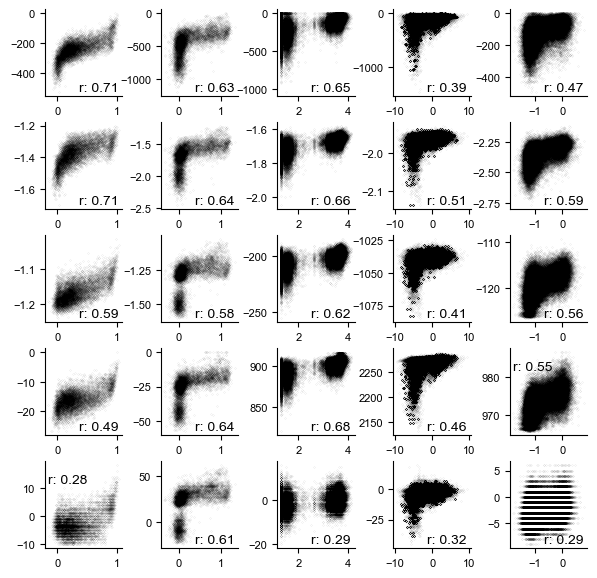

In [256]:
size= 0.001
c='black'
fig = plt.figure( figsize=(7,7))

spec = gs.GridSpec(ncols=5, nrows=5, figure= fig)
def plot_subplot_and_show_corr(x,y, ax,size =size, align='bottom_right'):
    ax.scatter(x,y, s=size, color=c)
    x_lim, y_lim = ax.get_xlim(), ax.get_ylim()

    if align == 'bottom_right':
        # calculate the x and y coordinates to position the text
        x_pos = x_lim[1] - (x_lim[1] - x_lim[0]) * 0.05
        y_pos = y_lim[0] +(y_lim[1] - y_lim[0]) * 0.175
        x_pos_2 = x_lim[1] - (x_lim[1] - x_lim[0]) * 0.05
        y_pos_2 = y_lim[0] +(y_lim[1] - y_lim[0]) * 0.025

        # use the text() method to add the text to the subplot at the calculated coordinates
        #ax.text(x_pos, y_pos, 'p r: {:.2f}'.format(pearsonr(x,y)[0]), ha="right", va="bottom")
        ax.text(x_pos_2, y_pos_2, 'r: {:.2f}'.format(spearmanr(x,y)[0]), ha="right", va="bottom")

    if align == 'top_left':
          # calculate the x and y coordinates to position the text
        x_pos = x_lim[0] + (x_lim[1] - x_lim[0]) * 0.05
        y_pos = y_lim[1] #-(y_lim[1] - y_lim[0]) * 0.05
        x_pos_2 = x_lim[0] + (x_lim[1] - x_lim[0]) * 0.05
        y_pos_2 = y_lim[1] - (y_lim[1] - y_lim[0]) * 0.15

        # use the text() method to add the text to the subplot at the calculated coordinates
        #ax.text(x_pos, y_pos, 'p r: {:.2f}'.format(pearsonr(x,y)[0]), ha="left", va="top")
        ax.text(x_pos_2, y_pos_2, 'r: {:.2f}'.format(spearmanr(x,y)[0]), ha="left", va="top")
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.tick_params(axis='both', which='minor', labelsize=6)    
# 3 pos at
plot_subplot_and_show_corr(df_mut_all_aa_merge.E3, df_mut_all_aa_merge['coves_pred_t0.1'], fig.add_subplot(spec[0,0]))
plot_subplot_and_show_corr(df_mut_all_aa_merge.E3, df_mut_all_aa_merge['ESM'], fig.add_subplot(spec[1,0]))
plot_subplot_and_show_corr(df_mut_all_aa_merge.E3, -df_mut_all_aa_merge['proteinMPNN'], fig.add_subplot(spec[2,0]))
plot_subplot_and_show_corr(df_mut_all_aa_merge.E3, df_mut_all_aa_merge['evc_pred'], fig.add_subplot(spec[3,0]))
plot_subplot_and_show_corr(df_mut_all_aa_merge.E3, df_mut_all_aa_merge['blosum_score'], fig.add_subplot(spec[4,0]), align='top_left')

# 10 pos at
plot_subplot_and_show_corr(df_10p_all.mean_lrr_norm, df_10p_all['coves_pred_t0.1'], fig.add_subplot(spec[0,1]))
plot_subplot_and_show_corr(df_10p_all.mean_lrr_norm, df_10p_all['ESM'], fig.add_subplot(spec[1,1]))
plot_subplot_and_show_corr(df_10p_all.mean_lrr_norm, -df_10p_all['proteinMPNN'], fig.add_subplot(spec[2,1]))
plot_subplot_and_show_corr(df_10p_all.mean_lrr_norm, df_10p_all['evc_pred'], fig.add_subplot(spec[3,1]))
plot_subplot_and_show_corr(df_10p_all.mean_lrr_norm, df_10p_all['blosum_score'], fig.add_subplot(spec[4,1]))

#gfp
plot_subplot_and_show_corr(df_all_gfp.DMS_score, df_all_gfp['RES_pred'], fig.add_subplot(spec[0,2]))
plot_subplot_and_show_corr(df_all_gfp.DMS_score, df_all_gfp['ESM'], fig.add_subplot(spec[1,2]))
plot_subplot_and_show_corr(df_all_gfp.DMS_score, df_all_gfp['Protein_MPNN_score'], fig.add_subplot(spec[2,2]))
plot_subplot_and_show_corr(df_all_gfp.DMS_score, df_all_gfp['evmut'], fig.add_subplot(spec[3,2]))
plot_subplot_and_show_corr(df_all_gfp.DMS_score, df_all_gfp['blosum'], fig.add_subplot(spec[4,2]))

#aav
plot_subplot_and_show_corr(df_all_aav.DMS_score, df_all_aav['RES_pred'], fig.add_subplot(spec[0,3]))
plot_subplot_and_show_corr(df_all_aav.DMS_score, df_all_aav['ESM'], fig.add_subplot(spec[1,3]))
plot_subplot_and_show_corr(df_all_aav.DMS_score, df_all_aav['Protein_MPNN_score'], fig.add_subplot(spec[2,3]))
plot_subplot_and_show_corr(df_all_aav.DMS_score, df_all_aav['evmut'], fig.add_subplot(spec[3,3]))
plot_subplot_and_show_corr(df_all_aav.DMS_score, df_all_aav['blosum'], fig.add_subplot(spec[4,3]))

#grb2
plot_subplot_and_show_corr(df_all_grb2.DMS_score, df_all_grb2['RES_pred'], fig.add_subplot(spec[0,4]))
plot_subplot_and_show_corr(df_all_grb2.DMS_score, df_all_grb2['ESM'], fig.add_subplot(spec[1,4]))
plot_subplot_and_show_corr(df_all_grb2.DMS_score, df_all_grb2['Protein_MPNN_score'], fig.add_subplot(spec[2,4]))
plot_subplot_and_show_corr(df_all_grb2.DMS_score, df_all_grb2['evmut'], fig.add_subplot(spec[3,4]), align='top_left')
plot_subplot_and_show_corr(df_all_grb2.DMS_score, df_all_grb2['blosum'], fig.add_subplot(spec[4,4]))

plt.subplots_adjust(wspace=0.5, hspace=0.3)
#fig.tight_layout()

plt.savefig(dout +'all_unsupervised_scores.png', format='png', dpi=300)
plt.show()
